In [ ]:
# default_exp features

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Features

> This module contains all the necessary functions for extracting and organizing features from videos.

In [ ]:
#hide
import cv2
import ffmpeg

import numpy as np

from abc import ABC, abstractmethod

from fastprogress import progress_bar

# tango
from tango.prep import *

from pathlib import Path

from matplotlib import pyplot as plt

from nbdev.showdoc import *

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#hide
path = Path("/tf/data/datasets/videos")
video_paths = sorted(path.glob("**/video.mp4")); video_paths[:6]

[PosixPath('/tf/data/datasets/videos/art_and_design/ibis_paint/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/ibis_paint/scenario2/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/pixel_art_paint/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/pixel_art_paint/scenario2/video.mp4'),
 PosixPath('/tf/data/datasets/videos/auto_and_vehicles/car_part/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/auto_and_vehicles/car_part/scenario2/video.mp4')]

In [ ]:
class Extractor(ABC):
 
    def __init__(self, extractor):
        self.extractor = extractor
        super().__init__()
    
    @abstractmethod
    def extract(self, img):
        pass

In [ ]:
class SIFTExtractor(Extractor):

    def extract(self, img):
        _, features = self.extractor.detectAndCompute(img, None)
        return features
    
class CNNExtractor(Extractor):
   
    def extract(self, img):
        # TODO: Add code to return extracted features from CNN
        pass

In [ ]:
imgs = get_rand_imgs(video_paths[0], 30_000, n = 5)

In [ ]:
extractor = SIFTExtractor(cv2.xfeatures2d.SIFT_create())

In [ ]:
features = extractor.extract(imgs[1]); features[:2].shape

(2, 128)

In [ ]:
#export
def gen_vcodebook(imgs, extractor, vwords = 10_000):
    """
        Constructs a visual codebook based on the given images.
        You can change vwords to increase the vocabulary of the codebook.
    """
    features_list = []
    for img in imgs:
        features = extractor.extract(img)
        features_list.extend(features)
    
    codebook = KMeans(n_clusters = vwords)
    codebook.fit(features_list)
    
    return codebook

In [ ]:
vwords = 1_000
codebook = gen_vcodebook(imgs, extractor, vwords)

In [ ]:
features = extractor.extract(imgs[0]);

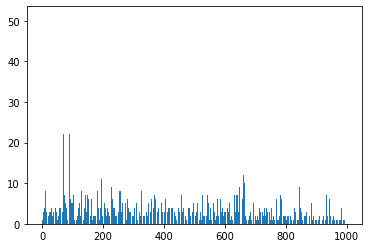

In [ ]:
labels = codebook.predict(features)
hist = numpy.histogram(labels, bins = vwords)
plt.bar(range(vwords), hist[0])
plt.show()

In [ ]:
#export
def get_df(imgs, extractor, codebook):
    """Generates the document frequency for the visual words"""
    hist = None
    for img in imgs:
        features = extractor.extract(img);
        vw = codebook.predict(features)
        if hist is not None:
            hist += np.clip(np.histogram(vw, bins = vwords)[0], 0, 1)
        else:
            hist = np.clip(np.histogram(vw, bins = vwords)[0], 0, 1)
    
    return hist

In [ ]:
df = get_df(imgs, extractor, codebook)

In [ ]:
df

array([5, 4, 3, 4, 4, 4, 4, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4,
       4, 4, 4, 5, 5, 5, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 3, 5, 2, 5, 5, 5,
       5, 5, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 4, 5, 4, 4, 5, 5, 4,
       5, 5, 5, 5, 4, 5, 5, 4, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5,
       5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5,
       5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4,
       4, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 3, 5, 5, 3, 5, 5, 5, 5, 4, 5, 5,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 4, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4,
       4, 4, 5, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4,
       4, 2, 4, 5, 4, 4, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 4, 4, 5, 5, 5,
       5, 5, 5, 4, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5,
       5, 4, 3, 5, 5, 5, 5, 4, 5, 5, 5, 4, 4, 5, 5,

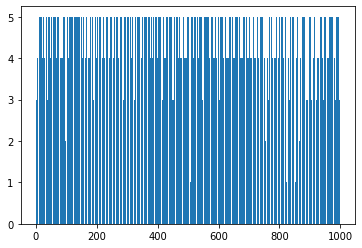

In [ ]:
plt.bar(range(vwords), df)
plt.show()

In [ ]:
#export
def get_bovw(vid_path, extractor, codebook):
    """Generates the bag of visual words (bovw) for an entire video."""
    vid = cv2.VideoCapture(str(vid_path))
    
    # checks whether frames were extracted 
    success = 1
    bovw = numpy.array([])
    for i in progress_bar(range(100)):
        # vid object calls read 
        # function extract frames 
        success, img = vid.read() 
        if success:
            features = extractor.extract(img)
            vw = codebook.predict(features)
            bovw = numpy.concatenate((bovw, vw))
    
    hist = numpy.histogram(bovw, bins = vwords)[0]
    return hist, bovw

In [ ]:
hist, bovw = get_bovw(video_paths[3], extractor, codebook)

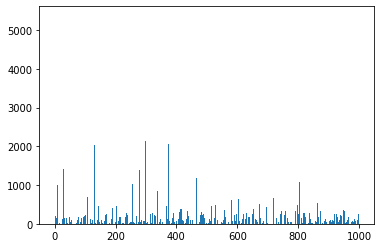

In [ ]:
plt.bar(range(vwords), hist)
plt.show()

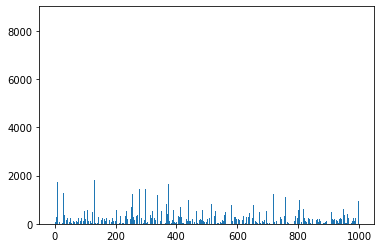

In [ ]:
plt.bar(range(vwords), hist)
plt.show()

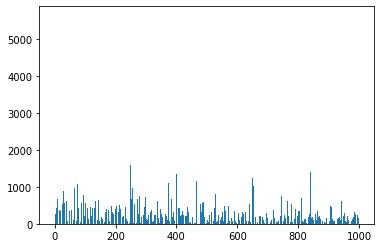

In [ ]:
plt.bar(range(vwords), hist)
plt.show()

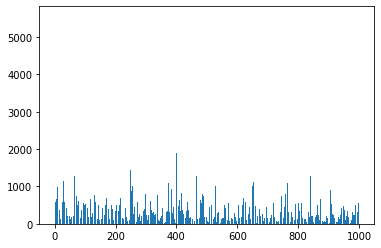

In [ ]:
plt.bar(range(vwords), hist)
plt.show()

In [ ]:
#export
def calc_tf_idf(tfs, dfs):
    tf_idf = numpy.array([])
    for tf, df in zip(tfs, dfs):
        tf = tf / numpy.sum(tfs)
        idf = numpy.log(len(tfs) / (df + 1))
        tf_idf = numpy.append(tf_idf, tf * idf)
    
    return tf_idf

In [ ]:
tf_idf4 = calc_tf_idf(hist, df)

In [ ]:
np.dot(tf_idf3, tf_idf4) / (np.linalg.norm(tf_idf3) * np.linalg.norm(tf_idf4))

0.9049203455361574

In [ ]:
np.dot(tf_idf4, tf_idf3) / (np.linalg.norm(tf_idf4) * np.linalg.norm(tf_idf3))

0.9049203455361574

In [ ]:
np.dot(tf_idf2, tf_idf3) / (np.linalg.norm(tf_idf2) * np.linalg.norm(tf_idf3))

0.5365116934450727

In [ ]:
np.dot(tf_idf, tf_idf3) / (np.linalg.norm(tf_idf) * np.linalg.norm(tf_idf3))

0.6075318986344004

In [ ]:
np.dot(tf_idf, tf_idf2) / (np.linalg.norm(tf_idf) * np.linalg.norm(tf_idf2))

0.9379406872000852

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_prep.ipynb.
Converted 01_features.ipynb.
Converted 02_eval.ipynb.
Converted index.ipynb.
Converted lesson1-pets.ipynb.
